# **Transformers learn in-context by gradient descent**
This specific notebook can be used to reproduce the results that assumes the standard token construction i.e. where $e_{2i} = x_i, e_{2i+1} = y_i$. We here show that the Transformer needs to first copy over neighboring tokens after which it can perform gradient descent steps in the following self-attention layers.

In [1]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple
!pip install --quiet --upgrade tensorflow
!pip install --quiet --upgrade jax
!pip install --quiet --upgrade jaxlib
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

!pip install --quiet -U dm-haiku
!pip install --quiet -U optax
import haiku as hk
import math
!pip install --quiet -U ml_collections
from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 573.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 23.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.6 MB/s eta 0:00:00


In [56]:
#@title Import internal sources (from github)
!git clone --quiet https://github.com/google-research/self-organising-systems.git /content/self-organising-systems > /dev/null 2>&1
%cd /content/self-organising-systems/transformers_learn_icl_by_gd
from src.transformer import Transformer
from src.data import create_reg_data_classic_token, create_weights
from src.config import config
from src.train import *

fatal: repository 'github.com/davidzhangsan/faster_finetuning_icl.git' does not exist


In the following you can play around with the experimental setup.
A couple of things to note:

1.   **use_softmax_only_in_the_first_layer** chooses if we want to use a softmax self-attention in the first layer. This seems to be neccessary to learn to copy in the first layer.  

2. **num_seeds** > 1 will rerun and show results of the experiment with the same config but with multiple seeds. For quick execution set this to 1.

3. The experiments run much quicker when using a GPU or TPU.

In [69]:
#@title Config
use_softmax = False #@param {type:"boolean"}
use_softmax_only_in_the_first_layer = True #@param {type:"boolean"}
num_layers = 2 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

#@title Config
config.classic_token_const = True
config.seed = 0

if use_softmax_only_in_the_first_layer:
  assert use_softmax == False

from datetime import datetime
now = datetime.now()
config.local_usage = True
config.distract_size = 0
config.training_steps = 100000
config.training_steps_gd = 100000
config.use_softmax = use_softmax
config.first_layer_sm = use_softmax_only_in_the_first_layer
config.use_non_lin_mix = False

####
config.deq = False
config.att_only_trans = True
####

config.layer_norm = False
config.out_proj = False
config.in_proj = False

#### Optimizer configs
config.adam = False  # Using SGD with momentum instead
config.momentum = 0.9  # Added momentum parameter
config.nesterov = True  # Using Nesterov momentum
config.pre_train_gd = True

config.dataset_size = 10
config.input_size = 10
config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10
config.lr = 0.0005

config.wd = 0.0
config.init_scale = 0.02 / config.num_layers
config.bs = 2048

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data_classic_token,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 1
config.seed = 0

config.gd_deq = True
config.pos_enc = True
config.pos_enc_size = 10
config.concat_pos_enc = True
config.key_size = 20
config.analyse = False

config.ana_copy  = True
config.num_seeds = num_seeds

change_dataloader()

In [70]:
#@title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train",
                     title1="Trained TF", title2="Test",
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',
                     second_axis=False, color_add=0, rw=10, num_iter_os=None,
                     allow_download=False, plot_num=1, two_plots=False,
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True,
                     height=3.5, width = 4, ax1=None, ax2=None):

  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)

  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)


  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range[:len(test)], test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)

  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range[:len(gt)],gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range[:len(test[:-rw])], test[:-rw], color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    print(num_iter_os, int(num_iter_os/len(inter)))
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)

  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range],
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)

  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)

  if plot_title is not None:
    pl.title(plot_title)

  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)

In [71]:
#@title Lists

loss_trans_list =  [[]  for _ in range(config.num_seeds)]
own_list =  [[]  for _ in range(config.num_seeds)]
own_one_list =  [[]  for _ in range(config.num_seeds)]
other_list =  [[]  for _ in range(config.num_seeds)]

In [72]:
#@title Training
eval_rng = jax.random.PRNGKey(10)
for cur_seed in range(0, config.num_seeds):
  config.seed = cur_seed
  optimiser, train_state, _, rng = init()
  rng, data_rng, eval_rng = jax.random.split(rng, 3)

  eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                               config.input_size,
                               config.dataset_size,
                               config.size_distract,
                               config.input_range,
                               config.weight_scale)

  for step in range(config.training_steps):
    rng, data_rng = jax.random.split(data_rng, 2)
    train_data = data_creator(jax.random.split(rng, num=config.bs),
                              config.input_size,
                              config.dataset_size,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)
    train_state, metrics = update(train_state, train_data, optimiser)
    if step % 500 == 0:
      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      own, own_one, other = analyse_copy(eval_data, train_state, eval_rng)

      loss_trans_list[cur_seed].append(loss_trans)
      own_list[cur_seed].append(own)
      own_one_list[cur_seed].append(own_one)
      other_list[cur_seed].append(other)
      display(("Current seed", cur_seed, "Training step", step,
                    "Trained TF loss", loss_trans.item(),
                    "Norm grad to own token", own.item(),
                    "Norm grad to next token", own_one.item(),
                    "Norm grad to all other tokens", other.item()),
                    display_id="Cur met")

('Current seed',
 0,
 'Training step',
 99500,
 'Trained TF loss',
 0.4164237082004547,
 'Norm grad to own token',
 3.1615474224090576,
 'Norm grad to next token',
 0.001959295244887471,
 'Norm grad to all other tokens',
 0.0019585725385695696)

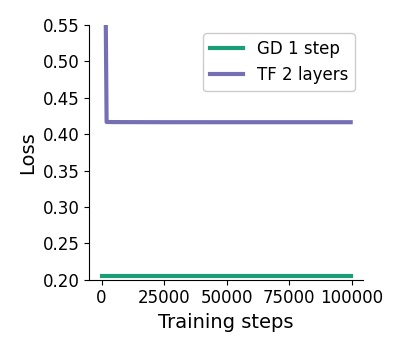

In [73]:
#@title Visualize Loss
losses_gd_list = [0.20468888]*len(loss_trans_list[0])
other_list_half = [o[:100] for o in other_list]
own_list_half = [o[:100] for o in own_list]
own_one_list_half = [o[:100] for o in own_one_list]
display_learning(loss_trans_list, [losses_gd_list], y_lim_u=0.55, y_lim_l=0.2,
                 loc_first='upper right', color_add=0.0, title2='GD 1 step', title1="TF 2 layers",
                 rw=1, title="train.pdf", allow_download=False, single_seeds=True,
                 num_iter_os=len(losses_gd_list)*500)

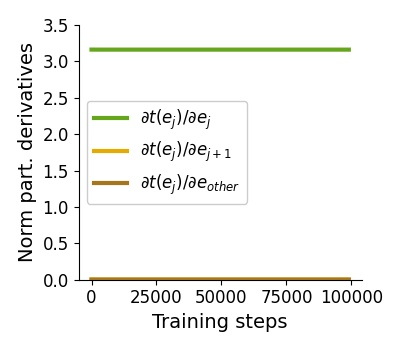

In [74]:
#@title Visualize sensitivity
display_learning(other_list_half, own_list_half, own_one_list_half, y_lim_u=3.5, y_lim_l=0.0,
                title3=r"$\partial t(e_j) / \partial e_{j+1}$", title2="$\partial t(e_j) / \partial e_{j}$", title1="$\partial t(e_j) / \partial e_{other}$",
                 loc_first='center left', color_add=0.5, label_title="Norm part. derivatives",
                 rw=1, title="train.pdf", allow_download=False, single_seeds=True,
                 num_iter_os=len(losses_gd_list)*500)

<ipython-input-75-2e86dddc05e0>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = pl.cm.get_cmap('Dark2')


Layer  0 Head  0


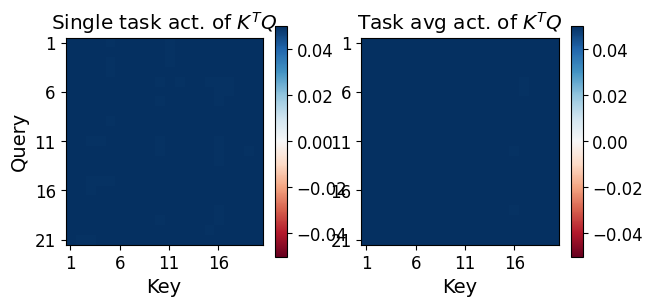

Layer  1 Head  0


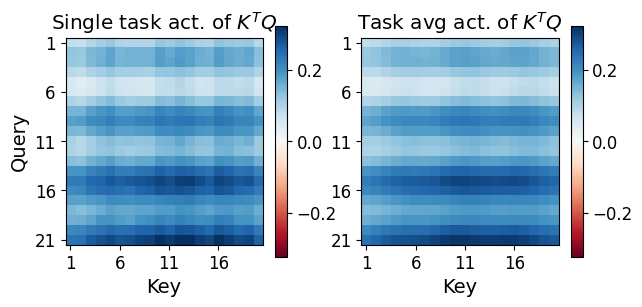

In [75]:
#@title Visualize attn heads
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})


attn = predict_attn.apply(train_state.params, eval_rng,
                                            eval_data[0], False)

import matplotlib.colors as mcolors
colors = pl.cm.get_cmap('Dark2')

for n in range(config.num_layers):
  for head in range(attn[n].shape[1]):
    print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(7, 3), ncols=2)
    ax1.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax1.set_yticklabels(range(1, config.key_size+2, 5))
    ax1.set_xticks(ticks=range(0, config.key_size, 5))
    ax1.set_xticklabels(range(1, config.key_size+1, 5))

    ax2.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax2.set_yticklabels(range(1, config.key_size+2, 5))
    ax2.set_xticks(ticks=range(0, config.key_size, 5))
    ax2.set_xticklabels(range(1, config.key_size+1, 5))

    ax1.set_xlabel("Key")
    ax1.set_title("Single task act. of $K^TQ$")
    ax1.set_ylabel("Query")
    ax2.set_xlabel("Key")
    ax2.set_title("Task avg act. of $K^TQ$")
    single = jnp.squeeze(attn[n][0, head, :, :])
    mean = jnp.mean(attn[n][:, head, :, :], axis=0)
    vmin = jnp.max(jnp.abs(single))
    vmin2 = jnp.max(jnp.abs(mean))
    vmin = np.max([vmin, vmin2])
    pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(mean, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()

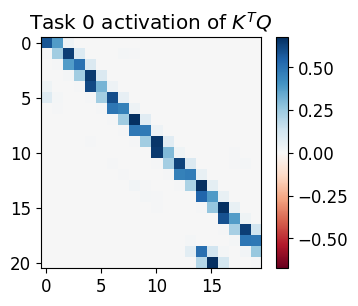

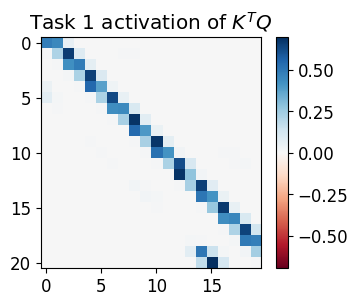

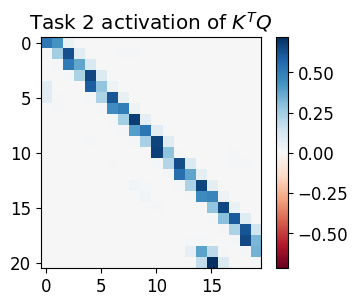

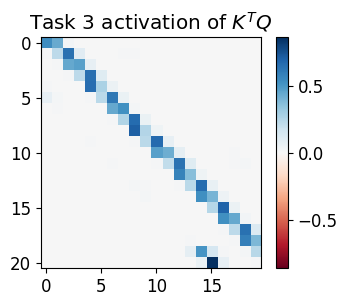

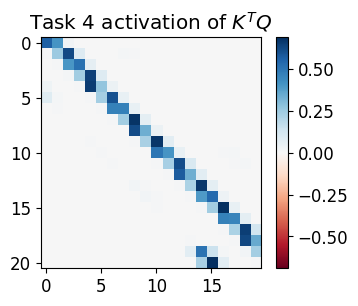

In [36]:
#@title Visualize attn heads for single tasks for layer 1

for i in range(5):
  fig, ax1 = pl.subplots(figsize=(4, 3))
  ax1.set_title("Task " + str(i) + " activation of $K^TQ$")
  single = jnp.squeeze(attn[0][i, 0, :, :])
  vmin = jnp.max(jnp.abs(single))
  pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin,)
  fig.colorbar(pos, ax=ax1, shrink=1)
  pl.show()

In [ ]:
#@title Visualize attn heads for single tasks for layer 2

for i in range(5):
  fig, ax1 = pl.subplots(figsize=(4, 3))
  ax1.set_title("Task " + str(i) + " activation of $K^TQ$")
  single = jnp.squeeze(attn[1][i, 0, :, :])
  vmin = jnp.max(jnp.abs(single))
  pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin,)
  fig.colorbar(pos, ax=ax1, shrink=1)
  pl.show()

Layer  0 Head  0


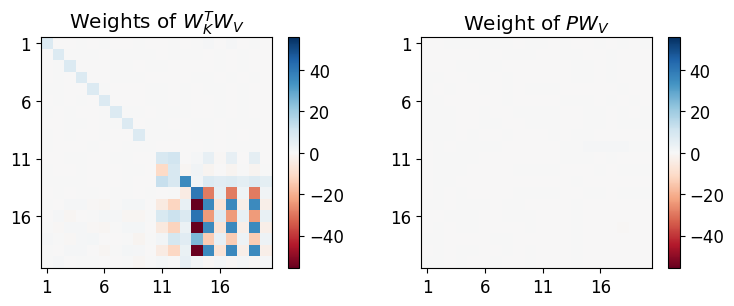

Layer  1 Head  0


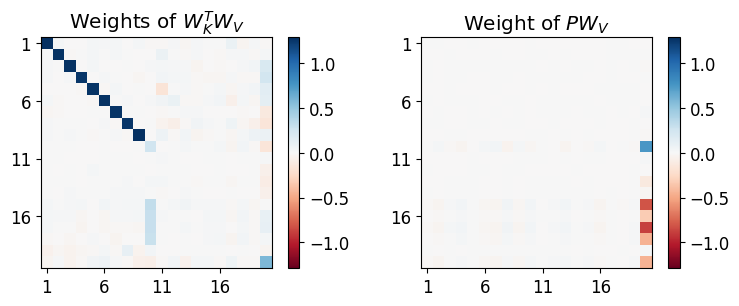

In [37]:
#@title Visualize weights
num_dim = config.key_size
for n in range(config.num_layers):
  for head in range(config.num_heads):
    KQ = jnp.identity(num_dim)
    LV = jnp.identity(num_dim)
    print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(9, 3), ncols=2)

    ax1.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax1.set_yticklabels(range(1, config.key_size+2, 5))
    ax1.set_xticks(ticks=range(0, config.key_size, 5))
    ax1.set_xticklabels(range(1, config.key_size+1, 5))

    ax2.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax2.set_yticklabels(range(1, config.key_size+2, 5))
    ax2.set_xticks(ticks=range(0, config.key_size, 5))
    ax2.set_xticklabels(range(1, config.key_size+1, 5))

    for k,v in train_state.params.items():
      if str(n) in k:
        #print(k, head, v['w'].shape)
        #print(k, head, v['w'].shape, )
        if "key" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim])
        elif "query" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim].T)
        elif "value" in k:
          LV = jnp.matmul(v['w'][:, head*num_dim: (head+1)*num_dim], LV)
        elif "linear" in k:
          LV = jnp.matmul(v['w'][head*num_dim: (head+1)*num_dim, :], LV)

    vmin = jnp.max(jnp.abs(KQ))
    vmin2 = jnp.max(jnp.abs(LV))
    vmin = np.max([vmin, vmin2])

    ax2.set_title("Weight of $PW_V$")
    ax1.set_title("Weights of $W^T_KW_V$")
    pos = ax1.imshow(KQ,cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(LV, cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()